In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./Data/PCAData.csv")
df.head()

,PC1,PC2,PC3,PC4,PC5,Player,Team
0,-5.640620,10.552256,-4.593444,-2.552969,-1.725329,Stephen Curry,GSW
1,-1.727259,9.796079,-2.410997,-4.667537,0.338773,Bradley Beal,WAS
2,-6.837932,11.720170,-0.658682,-5.041650,1.170356,Damian Lillard,POR
3,14.377135,14.024165,-3.078961,4.933598,7.909128,Joel Embiid,PHI
4,8.633649,13.502873,2.200106,-0.625522,0.246974,Giannis Antetokounmpo,MIL


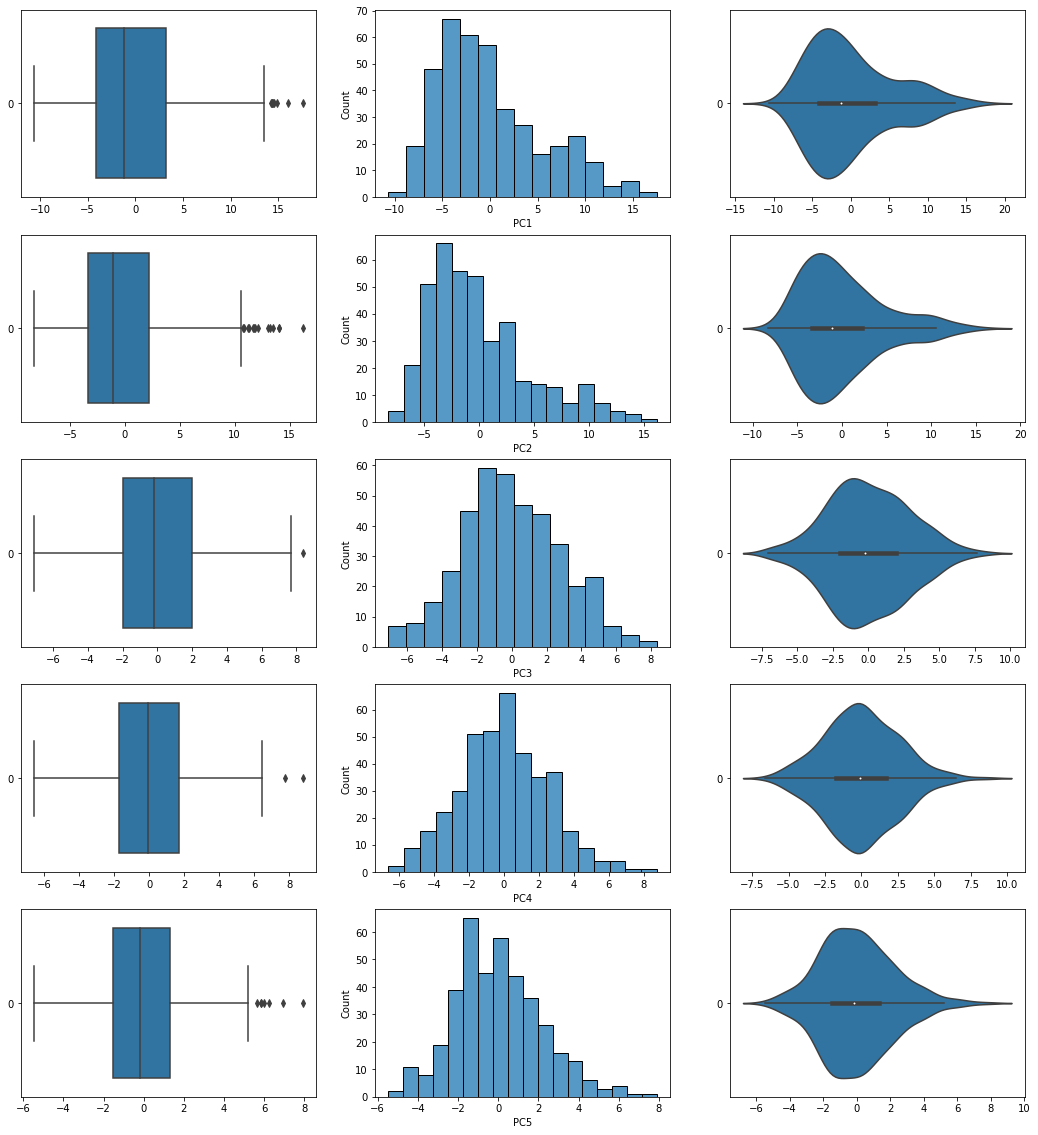

In [3]:
# Draw the distributions of all variables
f, axes = plt.subplots(5, 3, figsize=(18, 20))

for i in range (1, 6):
    sns.boxplot(data = df[f"PC{i}"], orient = "h", ax = axes[i - 1, 0])
    sns.histplot(data = df[f"PC{i}"], ax = axes[i - 1, 1])
    sns.violinplot(data = df[f"PC{i}"], orient = "h", ax = axes[i - 1, 2])